# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, preprocess_dataset



In [3]:
# here i get the X and y values from the csv, to be generated to cv_folds in the next block
#code is edited from slit_dataset in common utils
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
label_encoder = preprocessing.LabelEncoder()
# df['label'] #it was neg or pos
df['label'] = label_encoder.fit_transform(df['label'])
# df['label'] #now its 0 or 1
y_train = df['label'].to_numpy()
X_train = df.drop(['label', 'filename'], axis=1)


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [4]:
def generate_cv_folds_for_batch_sizes(parameters, X, y):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    #reference eg5.2a
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    for batch_size in parameters:
        kf = KFold(n_splits=5, shuffle=True, random_state=33)
        X_train_folds = []
        X_val_folds = []
        y_train_folds = []
        y_val_folds = []

        for train_idx, val_idx in kf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            X_train_fold_scaled, X_val_fold_scaled = preprocess_dataset(X_train_fold, X_val_fold)

            X_train_folds.append(X_train_fold_scaled)
            X_val_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)

        X_train_scaled_dict[batch_size] = X_train_folds
        X_val_scaled_dict[batch_size] = X_val_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds

    
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128,256,512,1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)
#so now for example y_train_dict[128] is a list of 5 arrays, each array is a different fold

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:

# YOUR CODE HERE
def train_loop(dataloader, model, loss_fn, optimizer): #from eg5.4a (classification of MINST images with ealy stopping, I had to edit to fit binary classification )
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X) #making predictions using model
        loss = loss_fn(pred, y) #computing loss by comparing predictions to actual label
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            correct += ((pred > 0.5).eq(y)).type(torch.float).sum().item()

    correct /= size

    return correct




def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, param_name):
    cross_validation_accuracies = {}
    cross_validation_times = {}
    for batch_size in batch_sizes:
        accuracies = []
        times = []
        for i in range(5): #iterate through the K folds (in here its 5) #can reference eg5.2a for training

            model = MLP(77, 128, 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            X_train = X_train_scaled_dict[batch_size][i]
            X_val = X_val_scaled_dict[batch_size][i]
            y_train = y_train_dict[batch_size][i]
            y_val = y_val_dict[batch_size][i]

            train_data = CustomDataset(X_train, y_train)
            val_data = CustomDataset(X_val, y_val)

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            val_acc = []

            for epoch in range(20): #arbitarily set epoch to 20 since question did not specify
                if epoch == 19:
                    start_time = time.time()
                #train each fold for 10 epochs, and here i used code from partA1
                train_loop(train_dataloader, model, loss_fn, optimizer)
    
                v_acc = test_loop(val_dataloader, model, loss_fn)
                val_acc.append(v_acc)


            end_time = time.time()
            accuracies.append(val_acc[-1])
            times.append(end_time - start_time)
        cross_validation_accuracies[batch_size] = np.mean(accuracies) #update the accuracy
        cross_validation_times[batch_size] = np.mean(times) #update the time taken
    
    return cross_validation_accuracies, cross_validation_times
    

batch_sizes = [128,256,512,1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

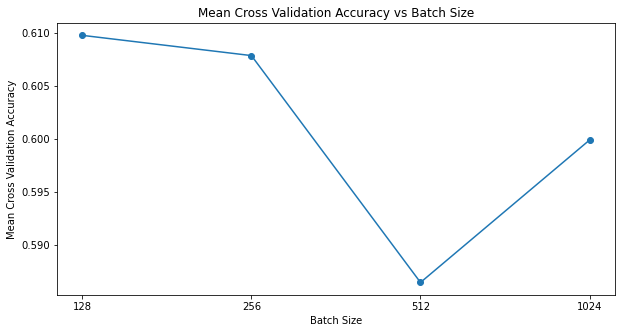

In [6]:
# YOUR CODE HERE
# Get the average accuracy for each batch size
accuracies = [acc for acc in cross_validation_accuracies.values()]
batch_sizes_arange = np.arange(len(batch_sizes))

plt.figure(figsize=(10, 5))
plt.plot(batch_sizes_arange, accuracies, marker='o')
plt.xticks(batch_sizes_arange, batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title('Mean Cross Validation Accuracy vs Batch Size')

plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [7]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': [time for time in cross_validation_times.values()]
                  })

df

,Batch Size,Last Epoch Time
0,128,0.228487
1,256,0.206615
2,512,0.177263
3,1024,0.160118


In [8]:
# YOUR CODE HERE
optimal_batch_size = 128
reason = "The optimal batch size is 128 as it has the highest average accuracy among all the batch sizes "